# Multi-layer Perceptron Example

In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

CURRENT TF VERSION IS [1.10.0]
PACKAGES LOADED


## LOAD

In [22]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/data/custom_data.npz"
l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg   = l['trainimg']
trainlabel = l['trainlabel']
testimg    = l['testimg']
testlabel  = l['testlabel']
imgsize    = l['imgsize']
categories = l['categories']
use_gray   = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)

['trainlabel', 'imgsize', 'trainimg', 'testimg', 'testlabel', 'use_gray', 'categories']
992 TRAIN IMAGES
249 TEST IMAGES
4096 DIMENSIONAL INPUT
5 CLASSES
[64 64]
[b'al_gore' b'MS' b'liv_tyler' b'Mrs_obama' b'Apple']


## DEFINE MODEL

In [23]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 256 
n_hidden_2 = 128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [24]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


## RUN

Epoch: 010/050 cost: 1.139399913
 TRAIN ACCURACY: 0.610
 TEST ACCURACY: 0.566
 108 MISSED


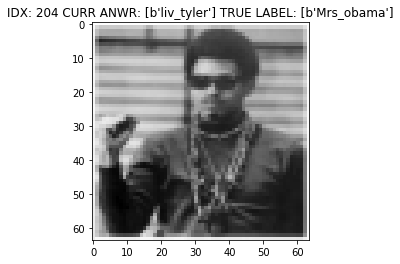

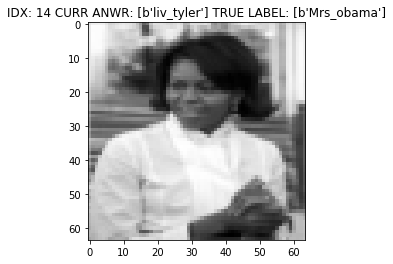

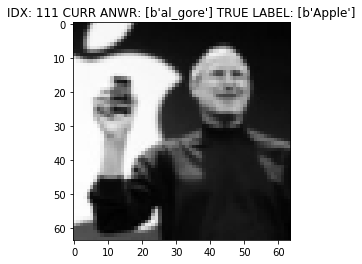

Epoch: 020/050 cost: 0.734279686
 TRAIN ACCURACY: 0.760
 TEST ACCURACY: 0.659
 85 MISSED


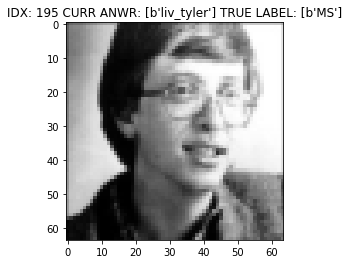

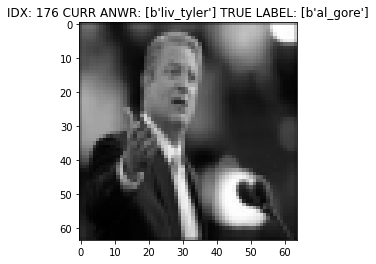

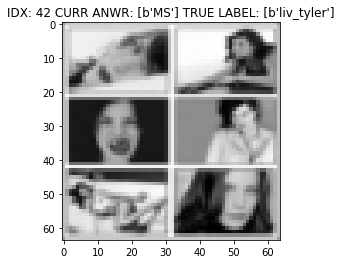

Epoch: 030/050 cost: 0.416057405
 TRAIN ACCURACY: 0.870
 TEST ACCURACY: 0.731
 67 MISSED


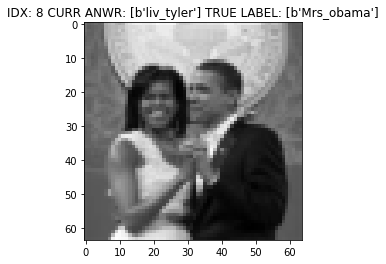

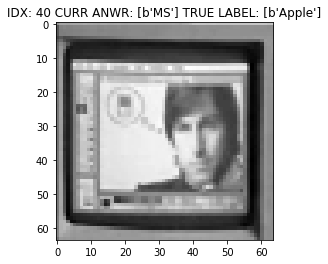

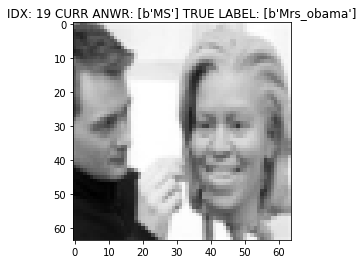

Epoch: 040/050 cost: 0.201857444
 TRAIN ACCURACY: 0.970
 TEST ACCURACY: 0.727
 68 MISSED


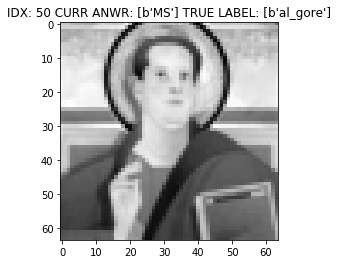

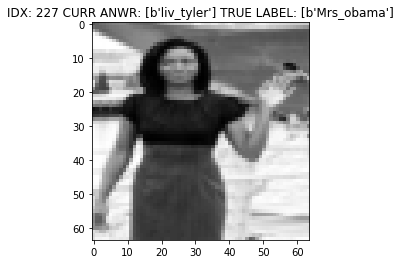

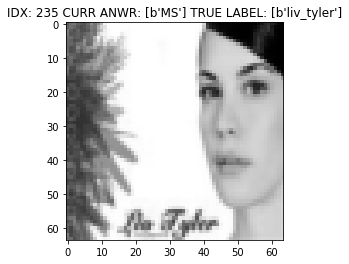

Epoch: 050/050 cost: 0.096004172
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.747
 63 MISSED


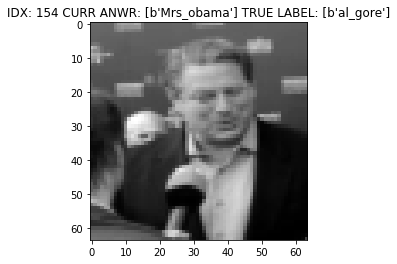

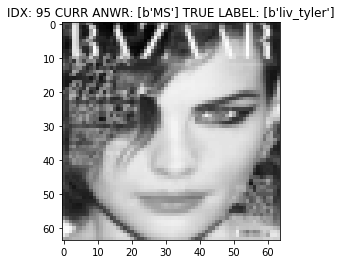

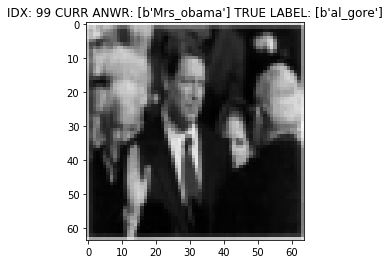

OPTIMIZATION FINISHED


In [25]:
# PARAMETERS
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    total_batch = int(ntrain/batch_size)
    randpermlist = np.random.permutation(ntrain)
    sun_cost = 0.
    for i in range(total_batch):
        randidx  = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        sun_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = sun_cost / total_batch
        
    # DISPLAY
    if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: testimg, y: testlabel}
        test_acc = sess.run(accr, feed_dict=feeds)
        print (" TEST ACCURACY: %.3f" % (test_acc))
        
    # PLOT
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        ntemp = int(ntest/batch_size) + 1 
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :]}
            missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        nmiss = len(missidxlist)
        print (" %d MISSED" % (nmiss))
        # PLOT MISSCLASSIFIED (UPTO THREE)
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx  = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss  = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :]}
        pred_miss   = sess.run(pred, feed_dict=feeds_miss)
        answ_miss   = np.argmax(pred_miss, 1)
        answ_corr   = np.argmax(testlabel[selmissidx, :], 1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw  = answ_miss[idx]
            ref  = answ_corr[idx]
            if use_gray != 0:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]" 
                % (cidx, anw_category, ref_category))
            plt.title(title_string) 
            plt.show() 
print ("OPTIMIZATION FINISHED")

# Model 1 (2 hidden layers)

In [32]:
# NETWORK TOPOLOGIES
n_input    = dim # 64 * 64
n_hidden_1 = 512 
n_hidden_2 = 128
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# DATA PREPROCESSING
x = (x - tf.reduce_mean(x, axis = 0, keepdims = True))
y = (y - tf.reduce_mean(y, axis = 0, keepdims = True))

    
# NETWORK PARAMETERS
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=(2/n_input)**0.5)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=(2/n_hidden_1)**0.5)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=(2/n_hidden_2)**0.5))
}

biases = {
    'b1': tf.Variable(tf.constant(0.05, shape = [n_hidden_1])),
    'b2': tf.Variable(tf.constant(0.05, shape = [n_hidden_2])),
    'out': tf.Variable(tf.constant(0.05, shape = [n_classes]))
}
print ("NETWORK READY")

##############################################################################################################################
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1 = tf.nn.dropout(layer_1, keep_prop)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    layer_2 = tf.nn.dropout(layer_2, keep_prop)
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
#reg_lambda = 0.0001
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
#reg_cost = tf.reduce_mean(tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out']))
#cost += reg_lambda * reg_cost / trainimg.shape[0]


# OPTIMIZER
#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.05
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                              1000, 0.96, staircase=True)
#optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
#optm = tf.train.RMSPropOptimizer(0.01, decay = 0.9).minimize(cost)
optm = tf.train.GradientDescentOptimizer(learning_rate = 0.002).minimize(cost)



# Accuracy
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

################################################################################################################################
# HYPERPARAMETERS
training_epochs = 300
batch_size      = 100

# For Curves
costs = []
train_costs = []
test_costs = []

with tf.Session() as sess :
    sess.run(init)
    for epoch in range(training_epochs) :
        total_iter = int(ntrain / batch_size)
        random_list = np.random.permutation(ntrain)
        sun_cost = 0
        for iter in range(total_iter) :
            # fetch batch_data
            randidx  = random_list[iter*batch_size:min((iter+1)*batch_size, ntrain-1)]
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]                
            feeds = {x: batch_xs, y: batch_ys, keep_prob: 1}
            
            sess.run(optm, feed_dict=feeds)
            sun_cost += sess.run(cost, feed_dict=feeds)
        # Calculating cost every epoch    
        avg_cost = sun_cost / total_iter
        costs.append(avg_cost)
        
        feed_train = {x : trainimg, y : trainlabel, keep_prob: 1.0}
        train_cost = sess.run(cost, feed_dict = feed_train)
        train_costs.append(train_cost)
        
        feed_test = {x : testimg, y : testlabel, keep_prob : 1.0}
        #test_acc = sess.run(accr, feed_dict=feed_test)
        #test_accs.append(test_acc)
        test_cost = sess.run(cost, feed_dict=feed_test)
        test_costs.append(test_cost)
        
        if((epoch+1) % 10 == 0) :
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
            print (" TRAIN COST: %.3f" % (train_cost))
            print (" TEST COSTY: %.3f" % (test_cost))
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("TEST ACCURACY : %.3f" % (test_acc))
            
        if(epoch == training_epochs -1) :
            train_acc = sess.run(accr, feed_dict = feed_train)
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("\nTRAIN ACCURACY : %.3f" % (train_acc))
            print("TEST ACCURACY : %.3f" % (test_acc))

#Performance Curve
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(costs)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
#ax1.title("Losses over epochs")

ax2.plot(train_costs, c = 'blue', label = 'train cost')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")

ax2.plot(test_costs, c = 'red', label = 'test cost')
ax2.legend()

plt.show()

print ("OPTIMIZATION FINISHED")  

NETWORK READY
FUNCTIONS READY


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_54' with dtype float
	 [[Node: Placeholder_54 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_54', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 497, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-4b2517be9813>", line 11, in <module>
    keep_prop = tf.placeholder(tf.float32)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5928, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_54' with dtype float
	 [[Node: Placeholder_54 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


NETWORK READY
FUNCTIONS READY
Epoch: 010/300 cost: 1.398418625
 TRAIN COST: 1.308
 TEST COSTY: 1.297
TEST ACCURACY : 0.514
Epoch: 020/300 cost: 1.295618547
 TRAIN COST: 1.205
 TEST COSTY: 1.230
TEST ACCURACY : 0.558
Epoch: 030/300 cost: 1.235176404
 TRAIN COST: 1.109
 TEST COSTY: 1.176
TEST ACCURACY : 0.578
Epoch: 040/300 cost: 1.148247719
 TRAIN COST: 1.022
 TEST COSTY: 1.128
TEST ACCURACY : 0.647
Epoch: 050/300 cost: 1.046941340
 TRAIN COST: 0.938
 TEST COSTY: 1.073
TEST ACCURACY : 0.631
Epoch: 060/300 cost: 1.015351580
 TRAIN COST: 0.855
 TEST COSTY: 1.029
TEST ACCURACY : 0.663
Epoch: 070/300 cost: 0.942223231
 TRAIN COST: 0.785
 TEST COSTY: 0.993
TEST ACCURACY : 0.683
Epoch: 080/300 cost: 0.902644111
 TRAIN COST: 0.726
 TEST COSTY: 0.965
TEST ACCURACY : 0.691
Epoch: 090/300 cost: 0.808320549
 TRAIN COST: 0.650
 TEST COSTY: 0.913
TEST ACCURACY : 0.707
Epoch: 100/300 cost: 0.767988920
 TRAIN COST: 0.603
 TEST COSTY: 0.905
TEST ACCURACY : 0.695
Epoch: 110/300 cost: 0.698488586
 TRAIN 

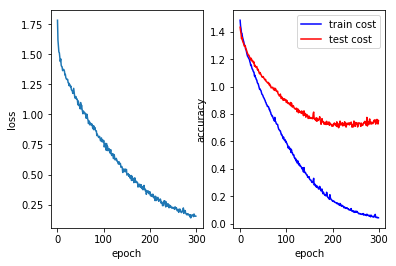

OPTIMIZATION FINISHED


In [36]:
# NETWORK TOPOLOGIES
n_input    = dim # 64 * 64
n_hidden_1 = 512 
n_hidden_2 = 128
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# DATA PREPROCESSING
x = (x - tf.reduce_mean(x, axis = 0, keepdims = True))
y = (y - tf.reduce_mean(y, axis = 0, keepdims = True))

    
# NETWORK PARAMETERS
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=(2/n_input)**0.5)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=(2/n_hidden_1)**0.5)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=(2/n_hidden_2)**0.5))
}

biases = {
    'b1': tf.Variable(tf.constant(0.05, shape = [n_hidden_1])),
    'b2': tf.Variable(tf.constant(0.05, shape = [n_hidden_2])),
    'out': tf.Variable(tf.constant(0.05, shape = [n_classes]))
}
print ("NETWORK READY")

##############################################################################################################################
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    layer_2 = tf.nn.dropout(layer_2, keep_prob)
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
reg_lambda = 0.0003
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
reg_cost = tf.reduce_mean(tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out']))
cost += reg_lambda * reg_cost / trainimg.shape[0]



# OPTIMIZER
#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.05
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                              1000, 0.96, staircase=True)
#optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
#optm = tf.train.RMSPropOptimizer(0.01, decay = 0.9).minimize(cost)
optm = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost)

# Accuracy
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

################################################################################################################################
# HYPERPARAMETERS
training_epochs = 300
batch_size      = 100

# For Curves
costs = []
train_costs = []
test_costs = []

with tf.Session() as sess :
    sess.run(init)
    for epoch in range(training_epochs) :
        total_iter = int(ntrain / batch_size)
        random_list = np.random.permutation(ntrain)
        sun_cost = 0
        for iter in range(total_iter) :
            # fetch batch_data
            randidx  = random_list[iter*batch_size:min((iter+1)*batch_size, ntrain-1)]
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]                
            feeds = {x: batch_xs, y: batch_ys, keep_prob : 0.5}

            sess.run(optm, feed_dict=feeds)
            sun_cost += sess.run(cost, feed_dict=feeds)
        # Calculating cost every epoch    
        avg_cost = sun_cost / total_iter
        costs.append(avg_cost)
        
        feed_train = {x : trainimg, y : trainlabel, keep_prob : 1.0}
        train_cost = sess.run(cost, feed_dict = feed_train)
        train_costs.append(train_cost)
        
        feed_test = {x : testimg, y : testlabel, keep_prob : 1.0}
        #test_acc = sess.run(accr, feed_dict=feed_test)
        #test_accs.append(test_acc)
        test_cost = sess.run(cost, feed_dict=feed_test)
        test_costs.append(test_cost)
        
        if((epoch+1) % 10 == 0) :
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
            print (" TRAIN COST: %.3f" % (train_cost))
            print (" TEST COSTY: %.3f" % (test_cost))
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("TEST ACCURACY : %.3f" % (test_acc))
            
        if(epoch == training_epochs -1) :
            train_acc = sess.run(accr, feed_dict = feed_train)
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("\nTRAIN ACCURACY : %.3f" % (train_acc))
            print("TEST ACCURACY : %.3f" % (test_acc))

#Performance Curve
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(costs)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
#ax1.title("Losses over epochs")

ax2.plot(train_costs, c = 'blue', label = 'train cost')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")

ax2.plot(test_costs, c = 'red', label = 'test cost')
ax2.legend()

plt.show()

print ("OPTIMIZATION FINISHED")  

# Model 2 (3 layers)

NETWORK READY
FUNCTIONS READY
Epoch: 010/400 cost: 1.497682293
 TRAIN COST: 1.465
 TEST COSTY: 1.423
TEST ACCURACY : 0.382
Epoch: 020/400 cost: 1.436751670
 TRAIN COST: 1.389
 TEST COSTY: 1.352
TEST ACCURACY : 0.426
Epoch: 030/400 cost: 1.365536120
 TRAIN COST: 1.314
 TEST COSTY: 1.297
TEST ACCURACY : 0.470
Epoch: 040/400 cost: 1.335788780
 TRAIN COST: 1.256
 TEST COSTY: 1.259
TEST ACCURACY : 0.526
Epoch: 050/400 cost: 1.259787387
 TRAIN COST: 1.193
 TEST COSTY: 1.209
TEST ACCURACY : 0.534
Epoch: 060/400 cost: 1.215073453
 TRAIN COST: 1.116
 TEST COSTY: 1.170
TEST ACCURACY : 0.602
Epoch: 070/400 cost: 1.162897282
 TRAIN COST: 1.038
 TEST COSTY: 1.123
TEST ACCURACY : 0.606
Epoch: 080/400 cost: 1.132909748
 TRAIN COST: 0.955
 TEST COSTY: 1.097
TEST ACCURACY : 0.647
Epoch: 090/400 cost: 1.058827559
 TRAIN COST: 0.884
 TEST COSTY: 1.039
TEST ACCURACY : 0.667
Epoch: 100/400 cost: 0.998618470
 TRAIN COST: 0.811
 TEST COSTY: 1.009
TEST ACCURACY : 0.667
Epoch: 110/400 cost: 0.891784370
 TRAIN 

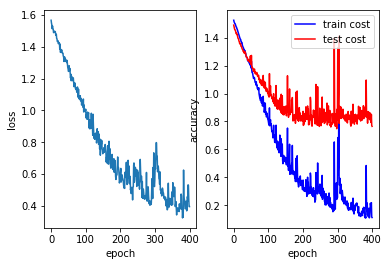

OPTIMIZATION FINISHED


In [29]:
# NETWORK TOPOLOGIES
n_input    = dim # 64 * 64
n_hidden_1 = 128 
n_hidden_2 = 64
n_hidden_3 = 64
n_classes  = nclass

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# DATA PREPROCESSING
x = (x - tf.reduce_mean(x, axis = 0, keepdims = True))
y = (y - tf.reduce_mean(y, axis = 0, keepdims = True))
    
# NETWORK PARAMETERS
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=(2/n_input)**0.5)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=(2/n_hidden_1)**0.5)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=(2/n_hidden_2)*0.5)),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes], stddev=(2/n_hidden_3)**0.5))
}
        #'h1' : tf.get_variable(name = 'weight1', shape = [n_input, n_hidden_1], initializer = tf.keras.initializers.he_normal()),
biases = {
    'b1': tf.Variable(tf.constant(0.1, shape = [n_hidden_1])),
    'b2': tf.Variable(tf.constant(0.1, shape = [n_hidden_2])),
    'b3': tf.Variable(tf.constant(0.1, shape = [n_hidden_3])),
    'out': tf.Variable(tf.constant(0.1, shape = [n_classes]))
}
print ("NETWORK READY")

##############################################################################################################################
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1 = tf.nn.dropout(layer_1, keep_prop)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    layer_2 = tf.nn.dropout(layer_2, keep_prop)
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, _weights['h3']), _biases['b3']))
    layer_3 = tf.nn.dropout(layer_3, keep_prop)
    return (tf.matmul(layer_3, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS
reg_lambda = 0.001

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
#reg_cost = tf.reduce_mean(tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) 
#                          + tf.nn.l2_loss(weights['h3']) + tf.nn.l2_loss(weights['out']))
#cost += reg_lambda / 2 * reg_cost


# OPTIMIZER
#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.05
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                              1000, 0.96, staircase=True)
#optm = tf.train.AdamOptimizer(learning_rate=0.009).minimize(cost) 
#optm = tf.train.RMSPropOptimizer(0.01, decay = 0.9).minimize(cost)
optm = tf.train.GradientDescentOptimizer(learning_rate = 0.022).minimize(cost)


#ACCURACY
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

################################################################################################################################
# HYPERPARAMETERS
training_epochs = 400
batch_size      = 100

# For Curves
costs = []
train_accs = []
train_costs = []
test_accs = []
test_costs = []

with tf.Session() as sess :
    sess.run(init)
    for epoch in range(training_epochs) :
        total_iter = int(ntrain / batch_size)
        random_list = np.random.permutation(ntrain)
        sun_cost = 0
        for iter in range(total_iter) :
            # fetch batch_data
            randidx  = random_list[iter*batch_size:min((iter+1)*batch_size, ntrain-1)]
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]                
            feeds = {x: batch_xs, y: batch_ys, keep_prob : 0.5}

            sess.run(optm, feed_dict=feeds)
            sun_cost += sess.run(cost, feed_dict=feeds)
            
        # Calculating cost every epoch    
        avg_cost = sun_cost / total_iter
        costs.append(avg_cost)
        
        feed_train = {x : trainimg, y : trainlabel, keep_prob : 1.0}
        #train_acc = sess.run(accr, feed_dict=feed_train)
        train_cost = sess.run(cost, feed_dict = feed_train)
        train_costs.append(train_cost)
        
        feed_test = {x : testimg, y : testlabel, keep_prob : 1.0}
        #test_acc = sess.run(accr, feed_dict=feed_test)
        #test_accs.append(test_acc)
        test_cost = sess.run(cost, feed_dict=feed_test)
        test_costs.append(test_cost)
        
        if((epoch+1) % 10 == 0) :
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
            print (" TRAIN COST: %.3f" % (train_cost))
            print (" TEST COSTY: %.3f" % (test_cost))
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("TEST ACCURACY : %.3f" % (test_acc))
            
        if(epoch == training_epochs -1) :
            train_acc = sess.run(accr, feed_dict = feed_train)
            test_acc = sess.run(accr, feed_dict = feed_test)
            print("\nTRAIN ACCURACY : %.3f" % (train_acc))
            print("TEST ACCURACY : %.3f" % (test_acc))

#Performance Curve
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(costs)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
#ax1.title("Losses over epochs")

ax2.plot(train_costs, c = 'blue', label = 'train cost')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")

ax2.plot(test_costs, c = 'red', label = 'test cost')
ax2.legend()

plt.show()

print ("OPTIMIZATION FINISHED")    